In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import itertools
from scipy.stats import spearmanr

from pathlib import Path

import os
import sys  

# set path for pixelator directory 
sys.path.insert(0, "/Users/janrkauert/pixelator/")

# load functions from pixelator
from pixelator.pixeldataset import PixelDataset
from pixelator.graph import Graph

# load standard workflow single cell functions
from colocalization_measures.plot import plot_mutliple_markers
from colocalization_measures.higher_order_similarity import calculate_higher_order_similarity
from colocalization_measures.adjusted_local_assortativity import calculate_adjusted_local_assorativity
from colocalization_measures.colocalization_scores import create_colocalization_scores

# get directory with graph eval files
path_name = "C:/Users/janrh/Downloads/Pixelator_data"

In [3]:
# all possible markers from the MPX method
marker_names = ['CD9', 'CD62P', 'CD27', 'CD36', 'mIgG2b', 'CD337', 'CD3E', 'CD274', 'CD55', 'CD161', 'CD14', 'CD48', 'CD82', 'CD64', 
                'CD11c', 'CD54', 'CD11b', 'CD44', 'CD154', 'B2M', 'CD268', 'CD18', 'CD37', 'CD4', 'CD29', 'CD11a', 'CD47', 'CD7', 
                'CD2', 'CD35', 'CD45', 'CD8', 'CD314', 'CD22', 'CD19', 'CD127', 'CD53', 'CD52', 'CD229', 'CD72', 'CD59', 'CD163', 'CD38', 
                'CD25', 'CD41', 'CD150', 'CD278', 'ACTB', 'CD152', 'mIgG1',  'CD5', 'CD26', 'CD197', 'CD50', 'CD328', 'CD279', 'CD200',
                'CD71', 'CD102', 'CD244', 'CD45RB', 'CD40', 'CD45RA', 'CD84', 'CD49D', 'CD162', 'CD1d', 'CD137', 'CD32', 'CD69', 'CD20', 'CD33', 
                'CD158', 'HLA-ABC', 'mIgG2a', 'CD86', 'CD43', 'CD16', 'TCRb', 'HLA-DR']

In [4]:
# marker combinations from the MPX paper
combinations = ["CD162_CD50", "CD162_CD37", "CD37_CD50", "B2M_CD162", "CD26_CD29",
                "CD37_CD45RB", "CD162_CD45", "CD162_HLA-ABC", "CD162_CD18", "CD162_CD26",
                "CD18_CD50", "CD50_HLA-ABC", "CD26_CD50", "CD45_CD50", "CD18_CD26", 
                "CD18_CD37", "CD37_CD45", "B2M_CD50", "B2M_CD37", "CD37_HLA-ABC",
                "CD50_CD7", "CD50_CD86", "CD16_CD37", "CD37_CD52", "CD48_CD50", "CD29_HLA-ABC",
                "CD50_CD59", "CD44_CD59", "CD162_CD59", "CD37_CD59", "CD2_CD37", "CD37_CD3E",
                "CD2_CD50", "CD3E_CD50", "CD162_CD2", "CD162_CD3E", "CD50_CD43"]

new_combinations = []
for combi in combinations:

    # transform combinations into workable format
    marker_1, marker_2 = combi.split("_")
    new_combinations.append((marker_1, marker_2))

# select markers for later method
combinations = new_combinations

#combinations = list(itertools.product(["CD50"], marker_names))

In [5]:
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S0"

# calculate pairwise colocalization scores
similarity_measure_df_S0 = create_colocalization_scores(marker_names, path_data, combinations)
similarity_measure_df_S0 = similarity_measure_df_S0.apply(lambda x: np.nan_to_num(x))

In [6]:
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S1"

# calculate pairwise colocalization scores
similarity_measure_df_S1 = create_colocalization_scores(marker_names, path_data, combinations)
similarity_measure_df_S1 = similarity_measure_df_S1.apply(lambda x: np.nan_to_num(x))

In [7]:
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/S3"

# calculate pairwise colocalization scores
similarity_measure_df_S3 = create_colocalization_scores(marker_names, path_data, combinations)
similarity_measure_df_S3 = similarity_measure_df_S3.apply(lambda x: np.nan_to_num(x))

In [8]:
# combine the two colocalization dataframes
df_original = pd.concat([similarity_measure_df_S3.T, similarity_measure_df_S1.T, similarity_measure_df_S0.T], 
                        keys=['Stimulated', 'Fixed control', 'Control']).reset_index().drop(labels=["level_1"], axis=1).set_index("level_0")

#df_original = df_original.drop(labels=["CD50_CD50"], axis=1)
df = df_original.melt(ignore_index=False)

In [9]:
top_pol_mean = df_original.groupby("level_0").get_group("Stimulated").apply(lambda x: np.mean(x))
gen_pop_mean = df_original.groupby("level_0").get_group("Fixed control").apply(lambda x: np.mean(x))
least_pol_mean = df_original.groupby("level_0").get_group("Control").apply(lambda x: np.median(x))

differential_1 = top_pol_mean - gen_pop_mean
differential_1 = differential_1.apply(lambda x: np.round(x, 5))

differential_2 = top_pol_mean - least_pol_mean
differential_2 = differential_2.apply(lambda x: np.round(x, 5))

In [63]:
from scipy.stats import wilcoxon

def statical_test(frist_sample, second_sample):

    statistical_significance = []
    for x_pos, marker_combination in enumerate(df_original.columns):
        scores_marker_1 = df_original.groupby("level_0").get_group(frist_sample)[marker_combination].values[:650]
        scores_marker_2 = df_original.groupby("level_0").get_group(second_sample)[marker_combination].values[:650]

        if max(scores_marker_1) == 0 and min(scores_marker_1) == 0 and max(scores_marker_2) == 0 and min(scores_marker_2) == 0:
            statistical_significance.append(np.nan)
        else:
            test = wilcoxon(x=scores_marker_1, y=scores_marker_2)
            
            p_value = test[1]
            if 0.01 < p_value:
                statistical_significance.append(np.nan)

            elif 0.001 < p_value and p_value < 0.01:
                statistical_significance.append(x_pos)

            elif 0.0001 < p_value and p_value < 0.001:
                statistical_significance.append(x_pos - 0.1)
                statistical_significance.append(x_pos + 0.1)

            else:
                statistical_significance.append(x_pos - 0.2)
                statistical_significance.append(x_pos)
                statistical_significance.append(x_pos + 0.2)

    return statistical_significance

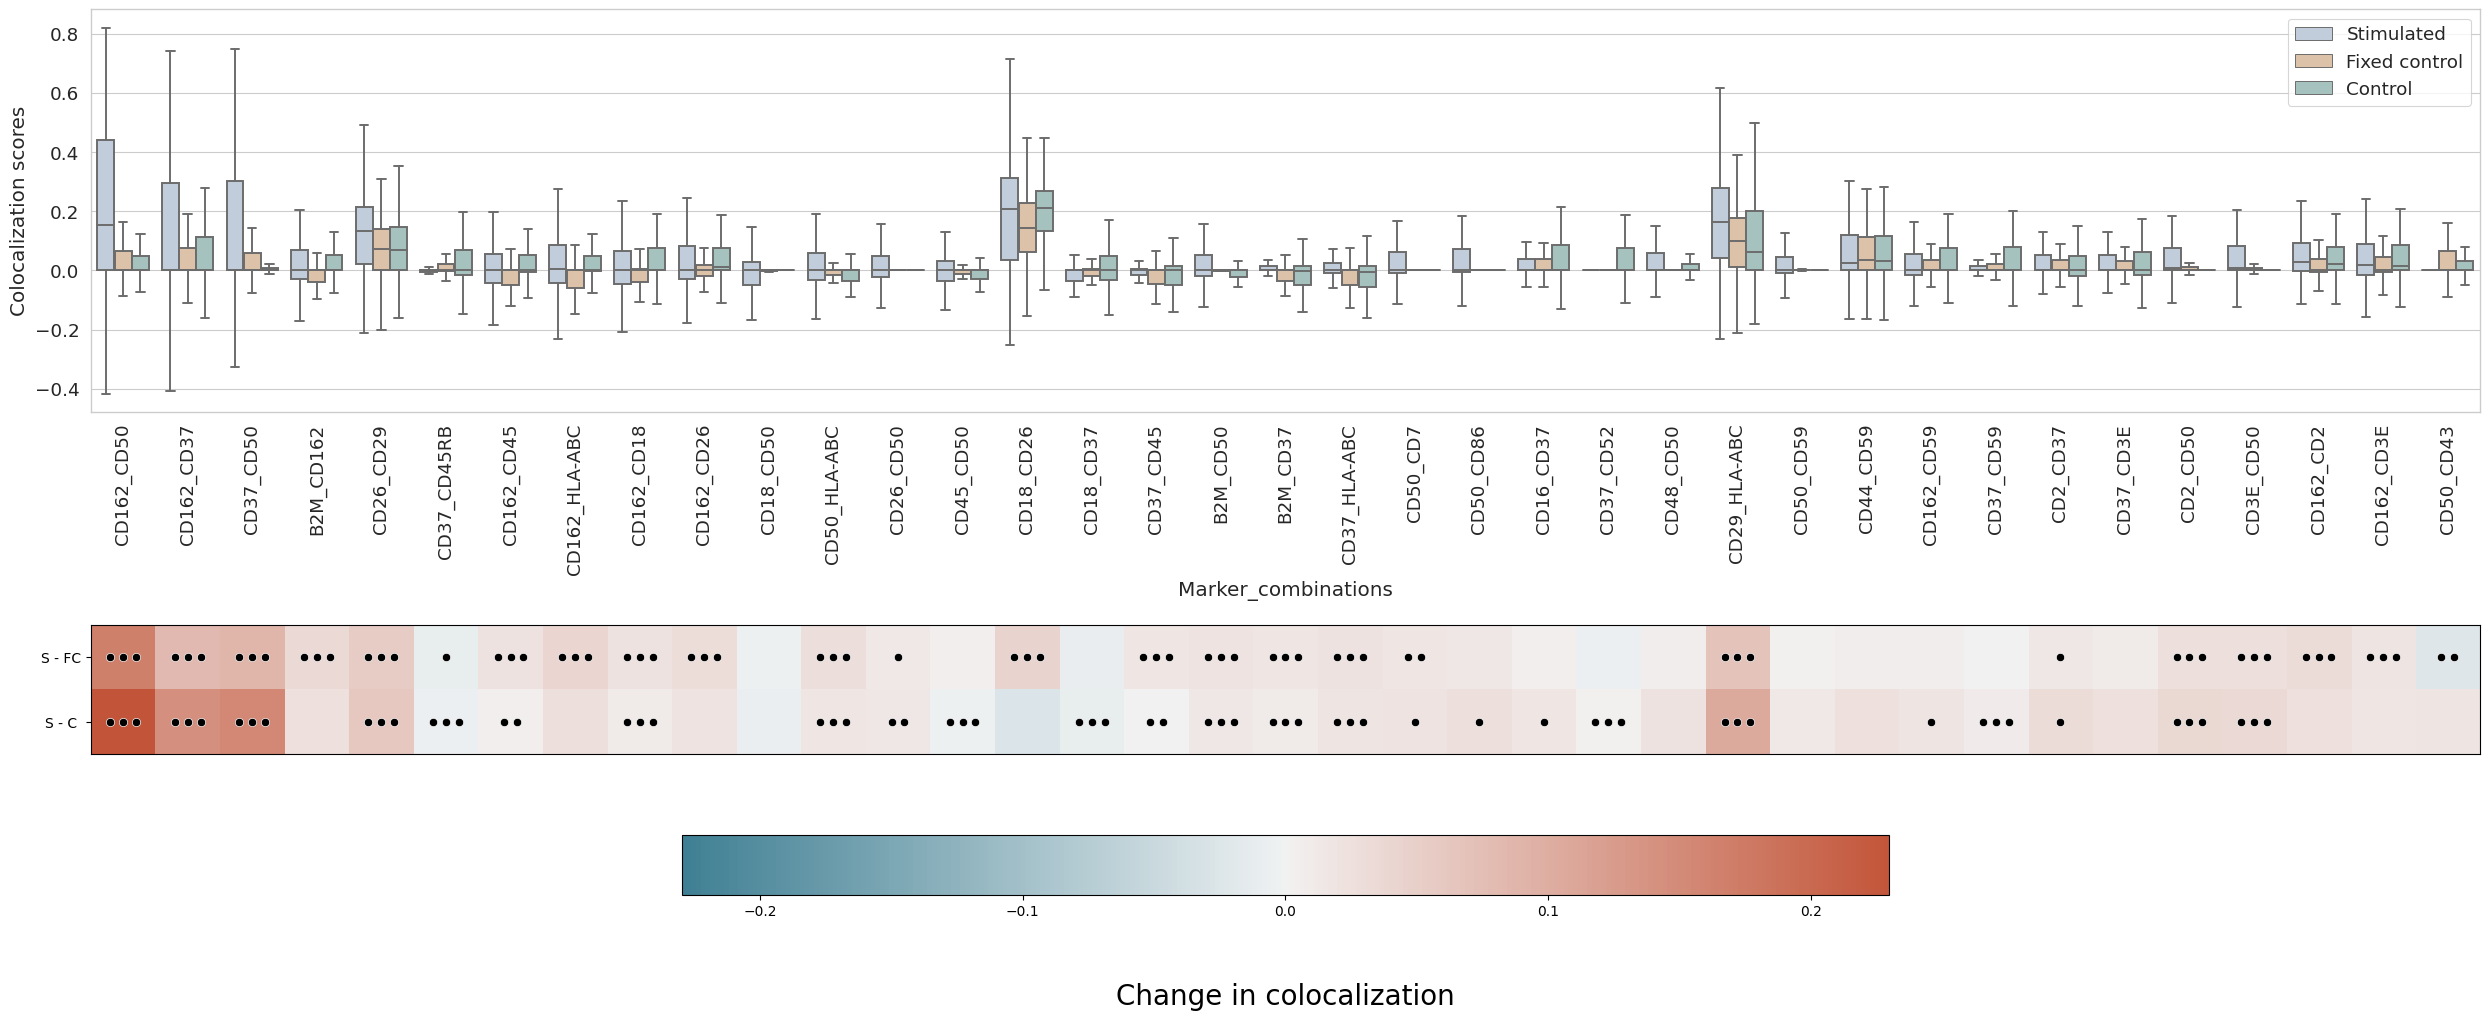

In [64]:
sns.set(rc={'figure.figsize':(40, 10)})
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5)

fig = plt.figure(figsize=(25, 10))
#fig.suptitle('Differential colocalization', fontsize=22)

ax = fig.add_subplot(2, 1, 1)
sns.boxplot(data=df, x="Marker_combinations", y="value", hue=df.index.values, showfliers=False, 
            width=0.8, palette=["#BDCCDF", "#E3C29F", "#A2C6C2"], linewidth=1.4)

# adjust axis
plt.xticks(rotation=90)
plt.ylabel("Colocalization scores")

sns.reset_orig()
ax = fig.add_subplot(2, 1, 2)
ax.set_title("Change in colocalization", fontsize=20, x=0.5, y=-2)

# get max values of the difference to create color bar values
max_values = max([max(np.abs(differential_1.values)), max(np.abs(differential_2.values)) ])

# test sigificane of mean shift for stimualted and fixed control sample, more dots = more sigificant
statists_S_FC = statical_test("Stimulated", "Fixed control")
sns.scatterplot(x=statists_S_FC, y=[0] * len(statists_S_FC), color="black", sizes=5)

# test sigificane of mean shift for stimualted and fixed control sample, more dots = more sigificant
statists_S_C = statical_test("Stimulated", "Control")
sns.scatterplot(x=statists_S_C, y=[1] * len(statists_S_C), color="black", sizes=5)

# plot colorbar indicading the shift of colocalization
im = plt.imshow([differential_1.values, differential_2.values], interpolation='none', aspect='equal', 
                cmap=sns.diverging_palette(220, 20, as_cmap=True), vmin=-max_values, vmax=max_values)

# add colorbar
plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)

# remove labels from the axis
ax.set_xticklabels([])
ax.set_yticklabels(["S - FC", "S - C "])
ax.set_xticks([])
ax.set_yticks([0, 1])

plt.tight_layout()
plt.show()
